# Importação de Pacotes

In [70]:
#leitura da base de dados
import pandas as pd
from pathlib import Path

#modelo preditivo escolhido
from tabpfn import TabPFNClassifier
from tabpfn.constants import ModelVersion

#validação cruzada
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
import numpy as np

#métricas
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

#pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer

In [71]:
def estimadores(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(
        ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
    )

    print(f"""
      Acurária: {round(acuracia,3)};
      Revocação: {round(recall,3)};
      F1: {round(F1,3)};
      Roc_Auc: {round(roc_auc,3)}""")

## Leitura DataFrame

In [72]:
direcao = Path("../..") / "data"
caminho = direcao / "enatjus.csv"

df = pd.read_csv(caminho)

In [73]:
df.columns

Index(['medicamento', 'cid', 'origem_tratada', 'selDefensoriaPublica',
       'selStaGenero', 'selEsfera', 'selIndicacaoConformidade',
       'selPrevistoProtocolo', 'selRegistroAnvisa', 'selDisponivelSus',
       'selOncologico', 'selExisteBiossimilar', 'conitec', 'y'],
      dtype='object')

## Escolha do Modelo e Parâmetros

In [74]:
modelo= TabPFNClassifier()

In [ ]:
parametros = {
    "modelo__n_estimators": [4, 8, 16, 32, 64],
    "modelo__eval_metric": ['f1', 'accuracy', 'balanced_accuracy', 'roc_auc', 'log_loss'],
    "modelo__average_before_softmax": [True, False],
    "modelo__softmax_temperature": [1.0, 0.9, 1.1, 1.2, 0.8]
}

# Aplicação de Pipelines

In [76]:
lista_X = ['medicamento', 'origem_tratada', 'selDefensoriaPublica',
       'selStaGenero', 'selEsfera', 'selIndicacaoConformidade',
       'selPrevistoProtocolo', 'selRegistroAnvisa', 'selDisponivelSus',
       'selOncologico', 'selExisteBiossimilar', 'conitec']


X = df[lista_X]

y = df["y"]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)


#função para pipeline
def subst_cat_nan(coluna):
    coluna = pd.DataFrame(coluna).copy()
    coluna = coluna.replace("NÃO_PREENCHIDO", np.nan)
    return coluna.to_numpy()


#pipeline de dummies
cat_prep = Pipeline(steps=[
    ('subst_cat_nan', FunctionTransformer(subst_cat_nan)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_prep, lista_X)
    ])


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('modelo', modelo)
    ])

searchCV_pipeline = RandomizedSearchCV(
    pipeline,
    parametros,
    scoring='roc_auc',
    refit='roc_auc',
    cv=5
)


### Fitting

In [77]:

searchCV_pipeline.fit(X_train, y_train)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peper\AppData\Local\Programs\Python\Python313\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn_common_utils\telemetry\core\decorators.py", line 288, in wrapper
    return _safe_call_with_telemetry(
        func, args, kwargs, model_method, param_names
    )
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn_common_utils\telemetry\core\decorators.py", line 332, in _safe_call_with_telemetry
    result = func(*args, **kwargs)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\classifier.py", line 815, in fit
    ensemble_configs, X, y = self._initialize_dataset_preprocessing(X, y, rng)
                             ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\classifier.py", line 604, in _initialize_dataset_preprocessing
    X, y, feature_names_in, n_features_in = validate_Xy_fit(
                                            ~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<5 lines>...
        ignore_pretraining_limits=self.ignore_pretraining_limits,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\utils.py", line 471, in validate_Xy_fit
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Number of samples 86566 in the input data is greater than the maximum number of samples 50000 officially supported by TabPFN. Set `ignore_pretraining_limits=True` to override this error!

--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peper\AppData\Local\Programs\Python\Python313\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn_common_utils\telemetry\core\decorators.py", line 288, in wrapper
    return _safe_call_with_telemetry(
        func, args, kwargs, model_method, param_names
    )
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn_common_utils\telemetry\core\decorators.py", line 332, in _safe_call_with_telemetry
    result = func(*args, **kwargs)
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\classifier.py", line 815, in fit
    ensemble_configs, X, y = self._initialize_dataset_preprocessing(X, y, rng)
                             ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\classifier.py", line 604, in _initialize_dataset_preprocessing
    X, y, feature_names_in, n_features_in = validate_Xy_fit(
                                            ~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<5 lines>...
        ignore_pretraining_limits=self.ignore_pretraining_limits,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tabpfn\utils.py", line 471, in validate_Xy_fit
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Number of samples 86567 in the input data is greater than the maximum number of samples 50000 officially supported by TabPFN. Set `ignore_pretraining_limits=True` to override this error!


### Métricas


      Acurária: 0.724;
      Revocação: 0.589;
      F1: 0.593;
      Roc_Auc: 0.691


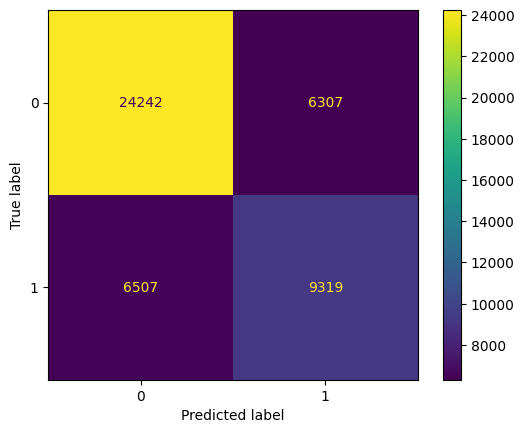

In [ ]:
estimadores(searchCV_pipeline, X_test, y_test)